## Classification

In [1]:
import collections
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import vae_lib.utils.nn_logger as log
from vae_lib.nn.simple_nn import SimpleNN
from vae_lib.nn.stochastic_nn_with_gmm import StochasticNNWithGmm
from vae_lib.graphics.plot_utils import plot_2d_latent_space
from vae_lib.graphics.plot_utils import plot_many_images
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.static_gmm_on_circle import StaticGmmOnCircle
from vae_lib.preprocessing.load_reuters import load_reuters
from vae_lib.preprocessing.load_poliblog import load_poliblog
from vae_lib.preprocessing.load_smsspam import load_smsspam

from vae_lib.preprocessing.load_mnist import load_mnist
from vae_lib.nn.dense_layer import DenseLayer
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle
from vae_lib.utils.mixture_assignments import create_mixture_assignments
from vae_lib.utils.measures import accuracy_for_score
from vae_lib.utils.measures import classification_ratio
from vae_lib.utils.measures import calculate_accuracy_np
from vae_lib.nn.vae_svae_standard import StandardVaeSvae


Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

In [2]:
mnist_train_perm, mnist_test, mnist_labels_train_perm, mnist_labels_test, mnist_onehot_encoder = load_mnist()

In [3]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters_dictionary = pickle.load( open(reuters_base_path+"dictionary.pkl", "rb" ))


In [4]:


reuters2_data_train_perm, reuters2_data_test, reuters2_labels_train_one_hot_perm, reuters2_labels_test_one_hot, reuters2_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=2)
reuters2_data_train_perm.shape, reuters2_data_test.shape, reuters2_labels_train_one_hot_perm.shape, reuters2_labels_test_one_hot.shape


((1064, 2000), (708, 2000), (1064, 2), (708, 2))

In [5]:
reuters3_data_train_perm, reuters3_data_test, reuters3_labels_train_one_hot_perm, reuters3_labels_test_one_hot, reuters3_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=3)
reuters3_data_train_perm.shape, reuters3_data_test.shape, reuters3_labels_train_one_hot_perm.shape, reuters3_labels_test_one_hot.shape


((1655, 2000), (1102, 2000), (1655, 3), (1102, 3))

In [6]:
reuters_base_path = "/Users/mjankowski/doc/data/reuters/for_python/"
reuters5_data_train_perm, reuters5_data_test, reuters5_labels_train_one_hot_perm, reuters5_labels_test_one_hot, reuters5_onehot_encoder = load_reuters(base_path=reuters_base_path, n_classes=5)
reuters5_data_train_perm.shape, reuters5_data_test.shape, reuters5_labels_train_one_hot_perm.shape, reuters5_labels_test_one_hot.shape


((2823, 2000), (1879, 2000), (2823, 5), (1879, 5))

In [7]:
poliblog_base_path = '/Users/mjankowski/doc/data/poliblog/for_python/'
poliblog_data_train_perm, poliblog_data_test, poliblog_ratings_train_one_hot_perm, poliblog_ratings_test_one_hot, poliblog_onehot_encoder = load_poliblog(base_path=poliblog_base_path)
poliblog_data_train_perm.shape, poliblog_data_test.shape, poliblog_ratings_train_one_hot_perm.shape, poliblog_ratings_test_one_hot.shape


((573, 1290), (200, 1290), (573, 2), (200, 2))

In [8]:
base_path = "/Users/mjankowski/doc/data/smsSpam/for_python/"
smsSpam_data_train_perm, smsSpam_data_test, smsSpam_labels_train_one_hot_perm, smsSpam_labels_test_one_hot, smsSpam_onehot_encoder = load_smsspam(base_path=base_path)
smsSpam_data_train_perm.shape, smsSpam_data_test.shape, smsSpam_labels_train_one_hot_perm.shape, smsSpam_labels_test_one_hot.shape


((742, 16), (200, 16), (742, 2), (200, 2))

In [209]:

def correct_accuracy_class_ratio_chart(accuracies, class_ratios):
    tmp_plot = pd.DataFrame({
        'accuracy': accuracies, 
        'class_ratio': class_ratios
    })

    plot_corrected = tmp_plot.groupby(['accuracy'], as_index=False).max()
    plot_corrected_sorted = plot_corrected.sort_values(['accuracy', 'class_ratio'], ascending=[0, 0])

#     plot_corrected_sorted_fixed = plot_corrected_sorted.copy()
    max_class_ratio = 0

    for index, row in plot_corrected_sorted.iterrows():
        max_class_ratio = max(row['class_ratio'], max_class_ratio)

        if row['class_ratio'] > max_class_ratio:
            max_class_ratio = row['class_ratio']
        else:
            row['class_ratio'] = max_class_ratio
            
    return plot_corrected_sorted

In [51]:
def train_dslgmm_model(
                train_data, 
                train_labels, 
                test_data, 
                test_labels, 
                hidden_dims, 
                epochs, 
                omega,
                mixture_assignments_train,
                mixture_assignments_test,
                one_hot_encoder,
                r
                ):
    
    #tf.reset_default_graph()
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.07,0.0],
        [0.0,0.007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=0,
        beta=0,
        gamma=1,
        omega=omega,
        r=r,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=epochs,
        log_interval=100
    )
        
#     train_encoded = model.sampleLatent(train_data)
#     test_encoded = model.sampleLatent(test_data)
#     test_decoded_labels = one_hot_encoder.inverse_transform(test_labels).reshape(-1)
#     train_decoded_labels = one_hot_encoder.inverse_transform(train_labels).reshape(-1)
    
    return model

In [129]:
# np.linspace(0.99, 1.0,1000)

In [46]:
np.concatenate([np.linspace(0,0.99,1000),np.linspace(0.99, 1.0,1000)])

array([0.00000000e+00, 9.90990991e-04, 1.98198198e-03, ...,
       9.99979980e-01, 9.99989990e-01, 1.00000000e+00])

In [224]:
def plot_confidence_accuracy(model, data, response, rows=1, base_pos=1):
    x_plot = np.linspace(start=0, stop=1, num=100)
    prediction, z_score_arr_unnorm, y_score_arr = model.predict(data)
    max_score = np.max(z_score_arr_unnorm)
    z_score_arr = z_score_arr_unnorm / max_score
    thresholds = np.concatenate([np.linspace(0,0.99,1000),np.linspace(0.99, 1.0,1000)])
    accuracy_plot = [accuracy_for_score(prediction, response, z_score_arr, threshold) for threshold in thresholds]
    class_ratio = [classification_ratio(z_score_arr, threshold) for threshold in thresholds]
    #score_plot = [classification_ratio(z_score_arr, s) for s in x_plot]
    
    y_accuracy_plot = [accuracy_for_score(prediction, response, y_score_arr, threshold) for threshold in thresholds]
    y_class_ratio = [classification_ratio(y_score_arr, threshold) for threshold in thresholds]
    
    fig = plt.figure(figsize=(20, 5))
    
    plt.subplot(rows, 3, base_pos)
    plt.plot(thresholds, accuracy_plot, marker='o')
    plt.plot(thresholds, y_accuracy_plot, marker='o')
    plt.xlabel("Threshold",fontsize=21)
    plt.ylabel("Accuracy",fontsize=21)
    
    plt.subplot(rows, 3, base_pos+1)
    plt.plot(thresholds, class_ratio, marker='o')
    plt.plot(thresholds, y_class_ratio, marker='o')
    plt.xlabel("Threshold",fontsize=21)
    plt.ylabel("Percentage of cases above threshold",fontsize=21)
    
    
    plt.subplot(rows, 3, base_pos+2)
    plt.plot(class_ratio, accuracy_plot, marker='o')
    plt.plot(y_class_ratio, y_accuracy_plot, marker='o')
    plt.xlabel("Percentage of cases meeting accuracy",fontsize=21)
    plt.ylabel("Accuracy",fontsize=21)
    plt.show()
    
    return np.array(thresholds), np.array(z_score_arr), np.array(accuracy_plot), np.array(class_ratio)

In [241]:
def plot_confidence_accuracy_simple(model, data, response, base_pos, rows, columns, title):
    x_plot = np.linspace(start=0, stop=1, num=100)
    prediction, z_score_arr_unnorm, y_score_arr = model.predict(data)
    max_score = np.max(z_score_arr_unnorm)
    z_score_arr = z_score_arr_unnorm / max_score
    thresholds = np.concatenate([np.linspace(0,0.99,1000),np.linspace(0.99, 1.0,1000)])
    accuracy_plot = [accuracy_for_score(prediction, response, z_score_arr, threshold) for threshold in thresholds]
    class_ratio = [classification_ratio(z_score_arr, threshold) for threshold in thresholds]
    #score_plot = [classification_ratio(z_score_arr, s) for s in x_plot]
    
    y_accuracy_plot = [accuracy_for_score(prediction, response, y_score_arr, threshold) for threshold in thresholds]
    y_class_ratio = [classification_ratio(y_score_arr, threshold) for threshold in thresholds]
    
    

    plt.subplot(rows, columns, base_pos)
#     plt.plot(class_ratio, accuracy_plot, label='||z||')
#     plt.plot(y_class_ratio, y_accuracy_plot, label='P(y)')



    hidden_plot = correct_accuracy_class_ratio_chart(accuracy_plot, class_ratio)
    plt.plot(hidden_plot['accuracy'].values, hidden_plot['class_ratio'].values, label='||z||')
    
    y_plot = correct_accuracy_class_ratio_chart(y_accuracy_plot, y_class_ratio)
    plt.plot(y_plot['accuracy'].values, y_plot['class_ratio'].values, label='P(y)') 
    
#     plt.plot(accuracy_plot, class_ratio, label='||z||', marker='o')
#     plt.plot(y_accuracy_plot, y_class_ratio, label='P(y)', marker='o')
    plt.title(title,fontsize=21)
    plt.xlabel("Accuracy",fontsize=21)
    plt.ylabel("Fraction of cases\n meeting accuracy",fontsize=21)
    plt.legend(loc='best')
#     plt.show()
    
    return np.array(thresholds), np.array(z_score_arr), np.array(accuracy_plot), np.array(class_ratio)

In [178]:
def get_latent_space(train_data, train_labels, test_data, test_labels, encoder, omega,mixture_assignments_train,mixture_assignments_test):
    log_folder = log.get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    K=train_labels.shape[1]
    init_cov = np.array([
        [0.007,0.0],
        [0.0,0.0007]
    ], dtype="float64")

    betas = np.ones(K)/K


    model = StochasticNNWithGmm(
        x_dim=train_data.shape[1],
        y_dim=train_labels.shape[1],
        hidden_dims=[512, 256, 128, 2],
        log_folder=log_folder,
        alpha=0,
        beta=0,#0.1,
        gamma=1,
        omega=omega,
        r=2.0,
        K=K,
        init_cov=init_cov,
        is_latent_supervised=True,
        mixture_weights=betas
    )
    model.fit(
        X_train=train_data, 
        y_train=train_labels, 
        X_test=test_data,
        y_test=test_labels,
        mixture_assignments_train=mixture_assignments_train,
        mixture_assignments_test=mixture_assignments_test,
        epochs=5,
        log_interval=10
    )

    train_encoded = model.sampleLatent(train_data)
    test_encoded = model.sampleLatent(test_data)
    test_decoded_labels = encoder.inverse_transform(test_labels).reshape(-1)
    train_decoded_labels = encoder.inverse_transform(train_labels).reshape(-1)
    return test_encoded, test_decoded_labels, train_encoded, train_decoded_labels


## Train MNIST using DSLGMM

In [66]:
label_mapping = {
    0: 0,
    1: 7,
    2: 4,
    3: 8,
    4: 9,
    5: 3,
    6: 5,
    7: 1,
    8: 6,
    9: 2
}

mixture_assignments_train = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_train_perm)

mixture_assignments_test = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_test)

mnist_dslgmm = train_dslgmm_model(
                train_data=mnist_train_perm, 
                train_labels=mnist_labels_train_perm, 
                test_data=mnist_test, 
                test_labels=mnist_labels_test, 
                hidden_dims=[512,256,128], 
                epochs=5, 
                omega=0.5,
                mixture_assignments_train=mixture_assignments_train,
                mixture_assignments_test=mixture_assignments_test,
                one_hot_encoder=mnist_onehot_encoder,
                r=2.0
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514132615
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9421111345291138
Test accuracy 0.9337142705917358
epoch: 1
Train accuracy 0.9617301821708679
Test accuracy 0.9511428475379944
epoch: 2
Train accuracy 0.9711745977401733
Test accuracy 0.954285740852356
epoch: 3
Train accuracy 0.9756349325180054
Test accuracy 0.9592857360839844
epoch: 4
Train accuracy 0.97987300157547
Test accuracy 0.9608571529388428


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


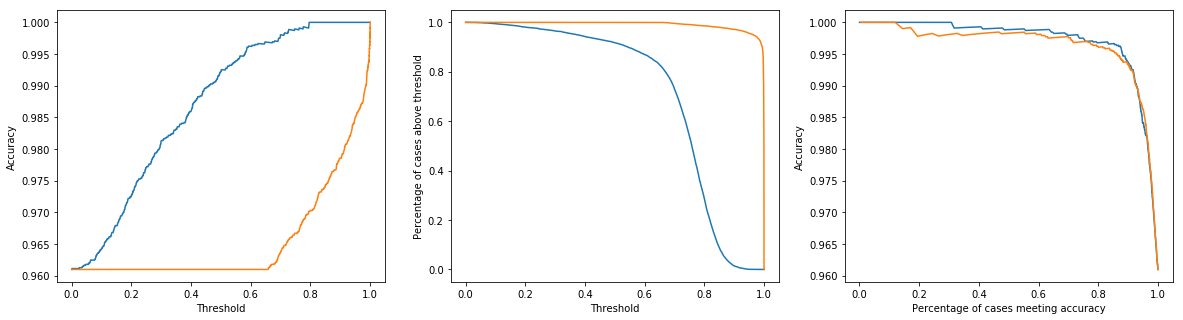

In [127]:
mnist_thresholds_train, mnist_score_arr_train, mnist_accuracy_train, mnist_class_ratio_train = plot_confidence_accuracy(
    mnist_dslgmm,
    mnist_test, 
    mnist_labels_test
)

In [112]:
len(mnist_thresholds_train),len(mnist_accuracy_train)

(100, 100)

In [119]:
pd.DataFrame({
    'threshold': mnist_thresholds_train, 
    'score': mnist_accuracy_train
}).head(5)

,threshold,score
0,0.000000,0.933143
1,0.015819,0.933143
2,0.031639,0.934049
3,0.047458,0.934842
4,0.063277,0.936711


In [101]:

poliblog_dslgmm = train_dslgmm_model(
                train_data=poliblog_data_train_perm, 
                train_labels=poliblog_ratings_train_one_hot_perm, 
                test_data=poliblog_data_test, 
                test_labels=poliblog_ratings_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=poliblog_ratings_train_one_hot_perm,
                mixture_assignments_test=poliblog_ratings_test_one_hot,
                one_hot_encoder=poliblog_onehot_encoder,
                r=1.5
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514152906
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 1
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 2
Train accuracy 0.7731239199638367
Test accuracy 0.6549999713897705
epoch: 3
Train accuracy 0.9493891596794128
Test accuracy 0.6549999713897705
epoch: 4
Train accuracy 0.9668411612510681
Test accuracy 0.6850000023841858
epoch: 5
Train accuracy 0.9825479984283447
Test accuracy 0.6499999761581421
epoch: 6
Train accuracy 0.9965096116065979
Test accuracy 0.675000011920929
epoch: 7
Train accuracy 0.9982547760009766
Test accuracy 0.7400000095367432
epoch: 8
Train accuracy 1.0
Test accuracy 0.7149999737739563
epoch: 9
Train accuracy 1.0
Test accuracy 0.75


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


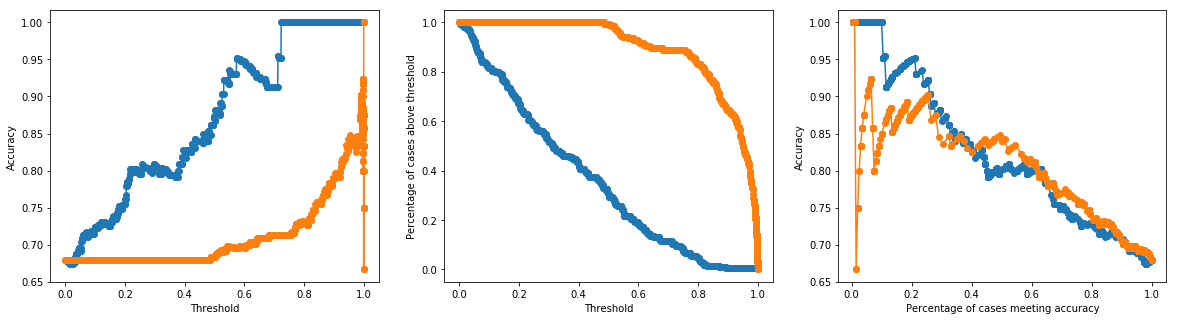

In [181]:

poliblog_thresholds_train, poliblog_score_arr_train, poliblog_accuracy_train, poliblog_class_ratio_train = plot_confidence_accuracy(
    poliblog_dslgmm,
    poliblog_data_test, 
    poliblog_ratings_test_one_hot
)

In [226]:
# pd.DataFrame({
#     'threshold': poliblog_thresholds_train, 
#     'score': poliblog_accuracy_train
# }).values

In [53]:

smsSpam_dslgmm = train_dslgmm_model(
                train_data=smsSpam_data_train_perm, 
                train_labels=smsSpam_labels_train_one_hot_perm, 
                test_data=smsSpam_data_test, 
                test_labels=smsSpam_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=smsSpam_labels_train_one_hot_perm,
                mixture_assignments_test=smsSpam_labels_test_one_hot,
                one_hot_encoder=smsSpam_onehot_encoder,
    r=2.0
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514132345
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.7237196564674377
Test accuracy 0.7099999785423279
epoch: 1
Train accuracy 0.7237196564674377
Test accuracy 0.7099999785423279
epoch: 2
Train accuracy 0.8571428656578064
Test accuracy 0.8199999928474426
epoch: 3
Train accuracy 0.8746630549430847
Test accuracy 0.8550000190734863
epoch: 4
Train accuracy 0.8935310244560242
Test accuracy 0.875
epoch: 5
Train accuracy 0.8948786854743958
Test accuracy 0.875
epoch: 6
Train accuracy 0.9002695679664612
Test accuracy 0.875
epoch: 7
Train accuracy 0.9056603908538818
Test accuracy 0.875
epoch: 8
Train accuracy 0.9070081114768982
Test accuracy 0.8849999904632568
epoch: 9
Train accuracy 0.9123989343643188
Test accuracy 0.875


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


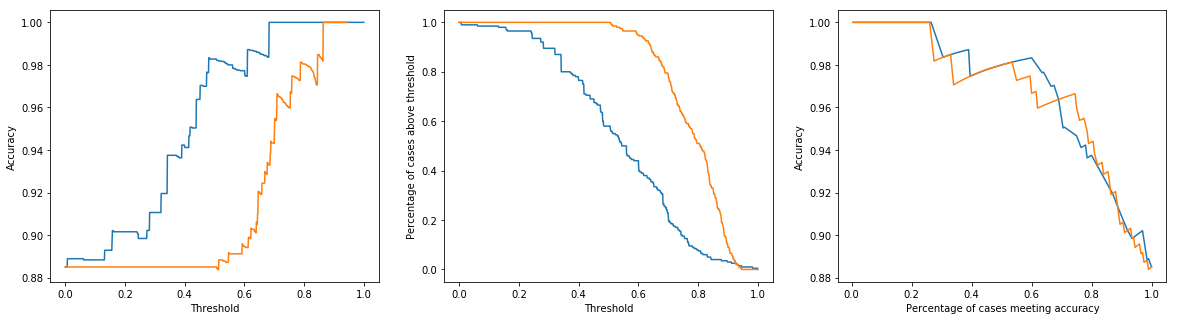

In [173]:
thresholds_train, score_arr_train, accuracy_train, class_ratio_train = plot_confidence_accuracy(
    smsSpam_dslgmm,
    smsSpam_data_test, 
    smsSpam_labels_test_one_hot
)

In [32]:

reuters2_dslgmm = train_dslgmm_model(
                train_data=reuters2_data_train_perm, 
                train_labels=reuters2_labels_train_one_hot_perm, 
                test_data=reuters2_data_test, 
                test_labels=reuters2_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=reuters2_labels_train_one_hot_perm,
                mixture_assignments_test=reuters2_labels_test_one_hot,
                one_hot_encoder=reuters2_onehot_encoder
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514124830
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.8374060392379761
Test accuracy 0.7824859023094177
epoch: 1
Train accuracy 0.9107142686843872
Test accuracy 0.8163841962814331
epoch: 2
Train accuracy 0.9577067494392395
Test accuracy 0.8474576473236084
epoch: 3
Train accuracy 0.9746240377426147
Test accuracy 0.9067796468734741
epoch: 4
Train accuracy 0.9877819418907166
Test accuracy 0.9110169410705566
epoch: 5
Train accuracy 0.9896616339683533
Test accuracy 0.9110169410705566
epoch: 6
Train accuracy 0.9943609237670898
Test accuracy 0.9110169410705566
epoch: 7
Train accuracy 0.9953007698059082
Test accuracy 0.9138417840003967
epoch: 8
Train accuracy 0.9953007698059082
Test accuracy 0.9293785095214844
epoch: 9
Train accuracy 1.0
Test accuracy 0.9194915294647217


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


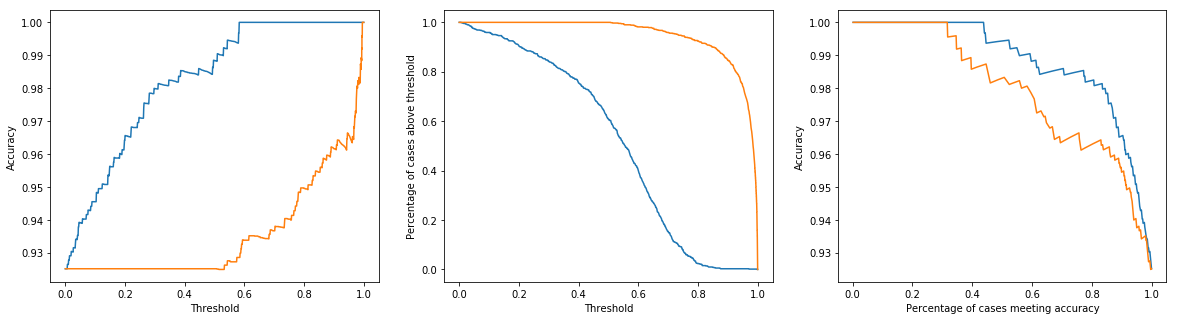

In [103]:
  
reuters2_thresholds_train, reuters2_score_arr_train, reuters2_accuracy_train, reuters2_class_ratio_train = plot_confidence_accuracy(
    reuters2_dslgmm,
    reuters2_data_test, 
    reuters2_labels_test_one_hot
)

In [122]:
pd.DataFrame({
    'threshold': reuters2_thresholds_train, 
    'score': reuters2_accuracy_train
}).head(5)

,threshold,score
0,0.000000,0.920904
1,0.015569,0.920680
2,0.031138,0.920680
3,0.046707,0.922967
4,0.062275,0.925608


In [34]:

reuters3_dslgmm = train_dslgmm_model(
                train_data=reuters3_data_train_perm, 
                train_labels=reuters3_labels_train_one_hot_perm, 
                test_data=reuters3_data_test, 
                test_labels=reuters3_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=reuters3_labels_train_one_hot_perm,
                mixture_assignments_test=reuters3_labels_test_one_hot,
                one_hot_encoder=reuters3_onehot_encoder
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514124934
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.4731117784976959
Test accuracy 0.4500907361507416
epoch: 1
Train accuracy 0.74803626537323
Test accuracy 0.6079854965209961
epoch: 2
Train accuracy 0.8858006000518799
Test accuracy 0.6932849287986755
epoch: 3
Train accuracy 0.9601208567619324
Test accuracy 0.7676951289176941
epoch: 4
Train accuracy 0.9854984879493713
Test accuracy 0.8049001693725586
epoch: 5
Train accuracy 0.9939576983451843
Test accuracy 0.8012704253196716
epoch: 6
Train accuracy 0.9969788789749146
Test accuracy 0.807622492313385
epoch: 7
Train accuracy 0.9975830912590027
Test accuracy 0.8121597170829773
epoch: 8
Train accuracy 0.9975830912590027
Test accuracy 0.8239564299583435
epoch: 9
Train accuracy 0.9975830912590027
Test accuracy 0.8176043629646301


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


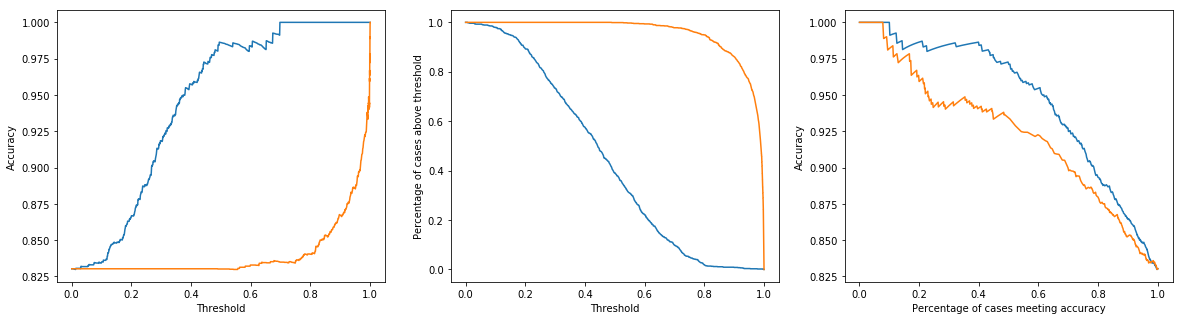

In [104]:
   
reuters3_thresholds_train, reuters3_score_arr_train, reuters3_accuracy_train, reuters3_class_ratio_train = plot_confidence_accuracy(
    reuters3_dslgmm,
    reuters3_data_test, 
    reuters3_labels_test_one_hot
)

In [227]:
# pd.DataFrame({
#     'threshold': reuters3_thresholds_train, 
#     'score': reuters3_accuracy_train
# }).head(200).values

In [36]:

reuters5_dslgmm = train_dslgmm_model(
                train_data=reuters5_data_train_perm, 
                train_labels=reuters5_labels_train_one_hot_perm, 
                test_data=reuters5_data_test, 
                test_labels=reuters5_labels_test_one_hot, 
                hidden_dims=[512,256,128], 
                epochs=10, 
                omega=0.5,
                mixture_assignments_train=reuters5_labels_train_one_hot_perm,
                mixture_assignments_test=reuters5_labels_test_one_hot,
                one_hot_encoder=reuters5_onehot_encoder
)



Starting autoencoder. Log folder=/tmp/class_vae/deep/14_05_2019/20190514125018
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.2685086727142334
Test accuracy 0.25385844707489014
epoch: 1
Train accuracy 0.4994686543941498
Test accuracy 0.3996806740760803
epoch: 2
Train accuracy 0.8069429397583008
Test accuracy 0.5699840188026428
epoch: 3
Train accuracy 0.9164009690284729
Test accuracy 0.6141564846038818
epoch: 4
Train accuracy 0.9734325408935547
Test accuracy 0.7003725171089172
epoch: 5
Train accuracy 0.9883103370666504
Test accuracy 0.7243214249610901
epoch: 6
Train accuracy 0.994686484336853
Test accuracy 0.7094199061393738
epoch: 7
Train accuracy 0.9968119263648987
Test accuracy 0.7216604351997375
epoch: 8
Train accuracy 0.9978746175765991
Test accuracy 0.7184672951698303
epoch: 9
Train accuracy 0.9982288479804993
Test accuracy 0.7147418856620789


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


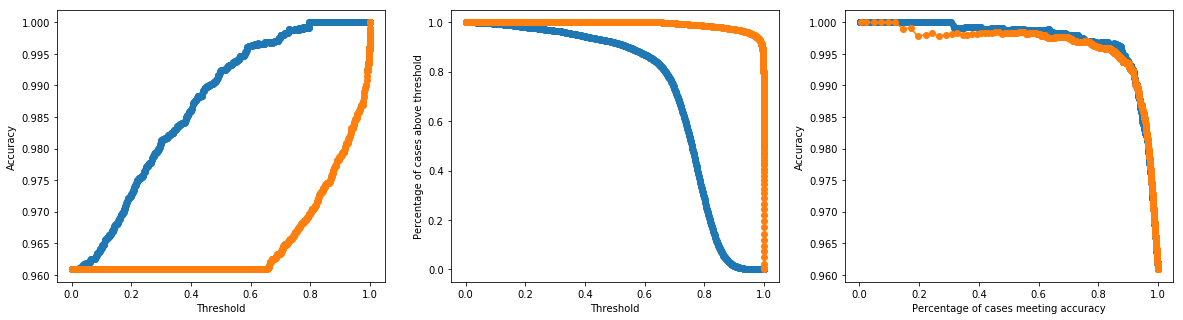

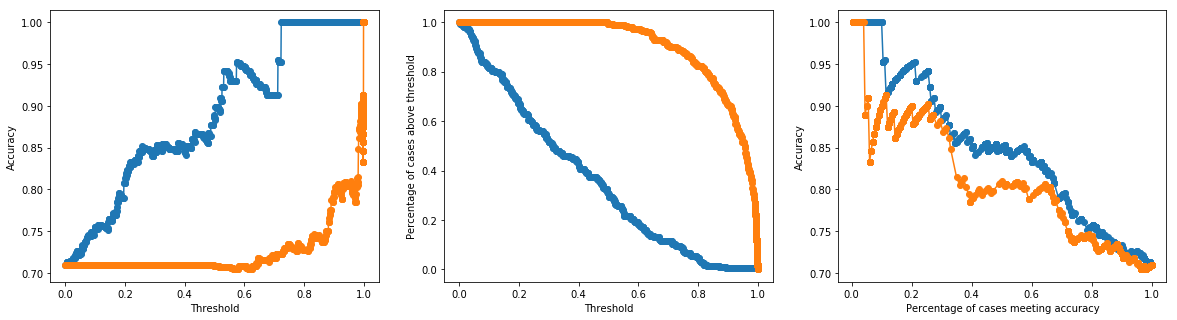

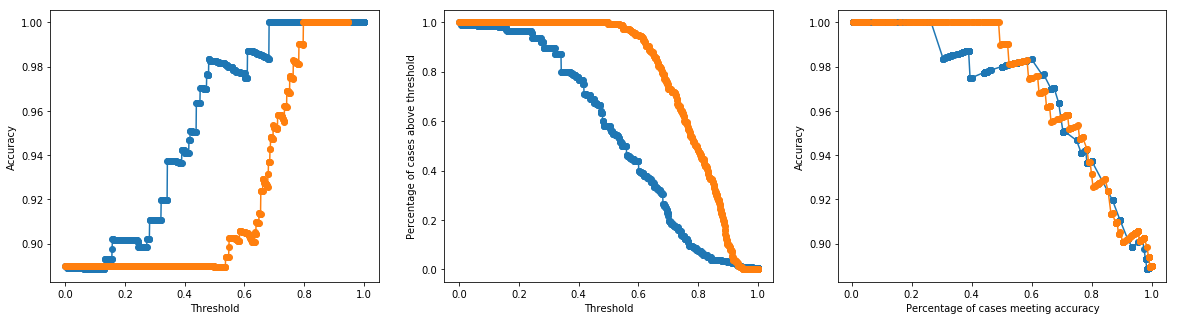

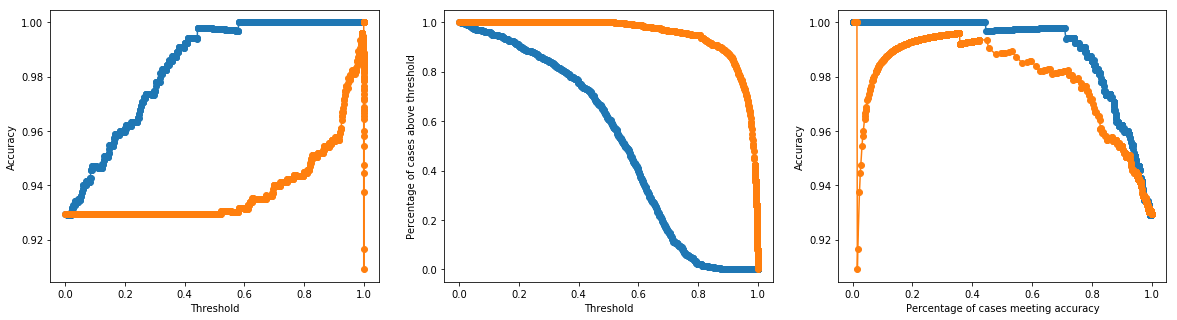

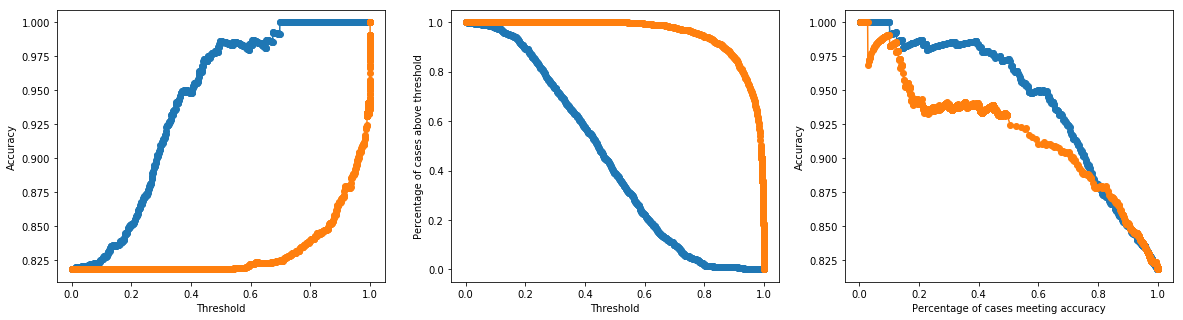

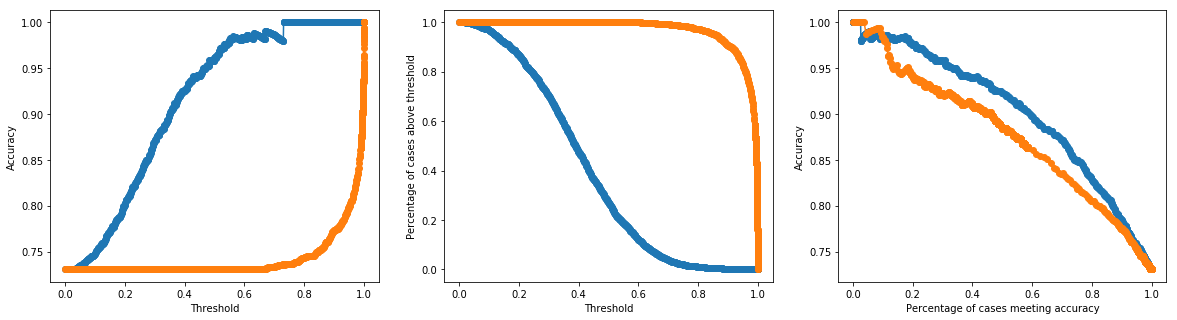

In [221]:
mnist_thresholds_train, mnist_score_arr_train, mnist_accuracy_train, mnist_class_ratio_train = plot_confidence_accuracy(
    mnist_dslgmm,
    mnist_test, 
    mnist_labels_test
)

poliblog_thresholds_train, poliblog_score_arr_train, poliblog_accuracy_train, poliblog_class_ratio_train = plot_confidence_accuracy(
    poliblog_dslgmm,
    poliblog_data_test, 
    poliblog_ratings_test_one_hot
)

smsSpam_thresholds_train, smsSpam_score_arr_train, smsSpam_accuracy_train, smsSpam_class_ratio_train = plot_confidence_accuracy(
    smsSpam_dslgmm,
    smsSpam_data_test, 
    smsSpam_labels_test_one_hot
)
    
reuters2_thresholds_train, reuters2_score_arr_train, reuters2_accuracy_train, reuters2_class_ratio_train = plot_confidence_accuracy(
    reuters2_dslgmm,
    reuters2_data_test, 
    reuters2_labels_test_one_hot
)
    
reuters3_thresholds_train, reuters3_score_arr_train, reuters3_accuracy_train, reuters3_class_ratio_train = plot_confidence_accuracy(
    reuters3_dslgmm,
    reuters3_data_test, 
    reuters3_labels_test_one_hot
)
    
reuters5_thresholds_train, reuters5_score_arr_train, reuters5_accuracy_train, reuters5_class_ratio_train = plot_confidence_accuracy(
    reuters5_dslgmm,
    reuters5_data_test, 
    reuters5_labels_test_one_hot
)

In [222]:
# pd.DataFrame({
#     'threshold': reuters5_thresholds_train, 
#     'score': reuters5_accuracy_train
# }).head(200).values

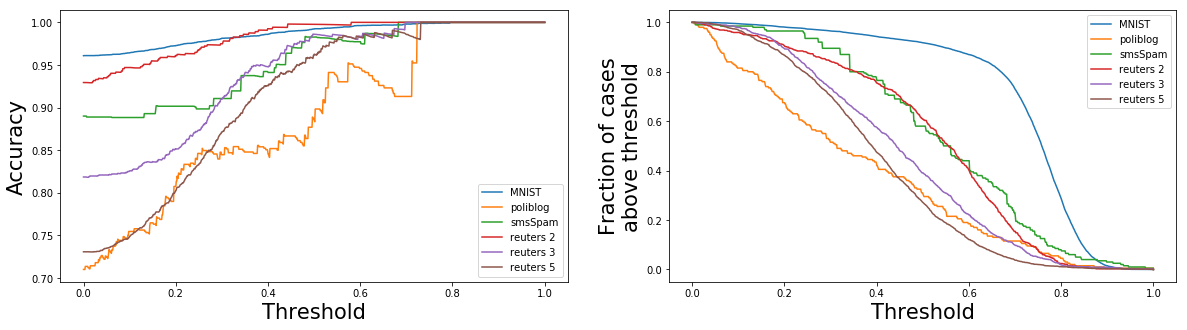

In [223]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(mnist_thresholds_train, mnist_accuracy_train, label='MNIST')
plt.plot(poliblog_thresholds_train, poliblog_accuracy_train, label='poliblog')
plt.plot(smsSpam_thresholds_train, smsSpam_accuracy_train, label='smsSpam')
plt.plot(reuters2_thresholds_train, reuters2_accuracy_train, label='reuters 2')
plt.plot(reuters3_thresholds_train, reuters3_accuracy_train, label='reuters 3')
plt.plot(reuters5_thresholds_train, reuters5_accuracy_train, label='reuters 5')
plt.xlabel("Threshold",fontsize=21)
plt.ylabel("Accuracy",fontsize=21)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(mnist_thresholds_train, mnist_class_ratio_train, label='MNIST')
plt.plot(poliblog_thresholds_train, poliblog_class_ratio_train, label='poliblog')
plt.plot(smsSpam_thresholds_train, smsSpam_class_ratio_train, label='smsSpam')
plt.plot(reuters2_thresholds_train, reuters2_class_ratio_train, label='reuters 2')
plt.plot(reuters3_thresholds_train, reuters3_class_ratio_train, label='reuters 3')
plt.plot(reuters5_thresholds_train, reuters5_class_ratio_train, label='reuters 5')
plt.xlabel("Threshold",fontsize=21)
plt.ylabel("Fraction of cases\nabove threshold",fontsize=21)
plt.legend(loc='best')

# plt.subplot(1, 3, 3)
# plt.plot(mnist_class_ratio_train, mnist_accuracy_train, label='MNIST')
# # plt.plot(poliblog_class_ratio_train, poliblog_accuracy_train)
# plt.plot(reuters2_class_ratio_train, reuters2_accuracy_train, label='reuters 2')
# plt.plot(reuters3_class_ratio_train, reuters3_accuracy_train, label='reuters 3')
# plt.plot(reuters5_class_ratio_train, reuters5_accuracy_train, label='reuters 5')
# plt.xlabel("Percentage of cases meeting accuracy",fontsize=14)
# plt.ylabel("Accuracy",fontsize=14)
# plt.legend(loc='best')

plt.savefig('/Users/mjankowski/Desktop/classification_score_ratio.png', bbox_inches='tight')

plt.show()

In [234]:
# plot_confidence_accuracy(
#     mnist_dslgmm,
#     mnist_test, 
#     mnist_labels_test
# )

# plot_confidence_accuracy(
#     poliblog_dslgmm,
#     poliblog_data_test, 
#     poliblog_ratings_test_one_hot
# )

# plot_confidence_accuracy(
#     reuters2_dslgmm,
#     reuters2_data_test, 
#     reuters2_labels_test_one_hot
# )

# plot_confidence_accuracy(
#     reuters3_dslgmm,
#     reuters3_data_test, 
#     reuters3_labels_test_one_hot
# )

# plot_confidence_accuracy(
#     reuters5_dslgmm,
#     reuters5_data_test, 
#     reuters5_labels_test_one_hot
# )
    
# plt.show()

In [245]:
def plot_confidence_accuracy_simple(model, data, response, base_pos, rows, columns, title):
    x_plot = np.linspace(start=0, stop=1, num=100)
    prediction, z_score_arr_unnorm, y_score_arr = model.predict(data)
    max_score = np.max(z_score_arr_unnorm)
    z_score_arr = z_score_arr_unnorm / max_score
    thresholds = np.concatenate([np.linspace(0,0.99,1000),np.linspace(0.99, 1.0,1000)])
    accuracy_plot = [accuracy_for_score(prediction, response, z_score_arr, threshold) for threshold in thresholds]
    class_ratio = [classification_ratio(z_score_arr, threshold) for threshold in thresholds]
    #score_plot = [classification_ratio(z_score_arr, s) for s in x_plot]
    
    y_accuracy_plot = [accuracy_for_score(prediction, response, y_score_arr, threshold) for threshold in thresholds]
    y_class_ratio = [classification_ratio(y_score_arr, threshold) for threshold in thresholds]
    
    

    plt.subplot(rows, columns, base_pos)
#     plt.plot(class_ratio, accuracy_plot, label='||z||')
#     plt.plot(y_class_ratio, y_accuracy_plot, label='P(y)')



    hidden_plot = correct_accuracy_class_ratio_chart(accuracy_plot, class_ratio)
    plt.plot(hidden_plot['accuracy'].values, hidden_plot['class_ratio'].values, label='||z||')
    
    y_plot = correct_accuracy_class_ratio_chart(y_accuracy_plot, y_class_ratio)
    plt.plot(y_plot['accuracy'].values, y_plot['class_ratio'].values, label='P(y)') 
    
#     plt.plot(accuracy_plot, class_ratio, label='||z||', marker='o')
#     plt.plot(y_accuracy_plot, y_class_ratio, label='P(y)', marker='o')
    plt.title(title,fontsize=21)
    plt.xlabel("Accuracy",fontsize=21)
    plt.ylabel("Fraction of cases\n meeting accuracy",fontsize=21)
    plt.legend(loc='best',fontsize=21)
    plt.tick_params(axis='both', which='major', labelsize=21)
#     plt.show()
    
    return np.array(thresholds), np.array(z_score_arr), np.array(accuracy_plot), np.array(class_ratio)

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


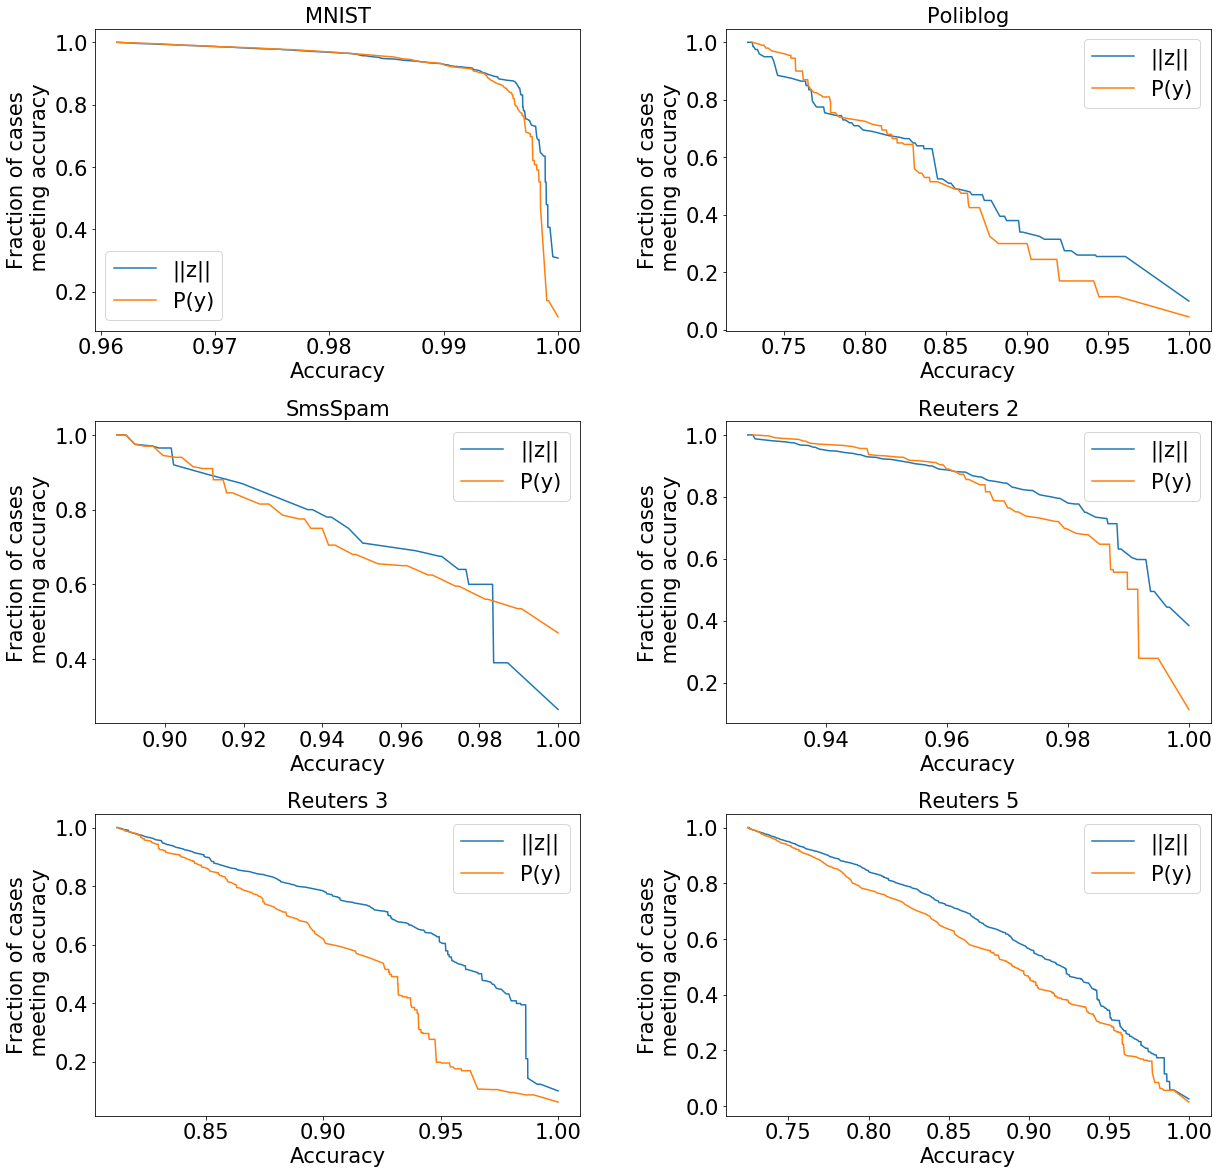

In [259]:
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)


plot_confidence_accuracy_simple(
    mnist_dslgmm,
    mnist_test, 
    mnist_labels_test,
    rows=3,
    columns=2,
    base_pos=1,
    title="MNIST"
)

plot_confidence_accuracy_simple(
    poliblog_dslgmm,
    poliblog_data_test, 
    poliblog_ratings_test_one_hot,
    rows=3,
    columns=2,
    base_pos=2,
    title="Poliblog"
)

plot_confidence_accuracy_simple(
    smsSpam_dslgmm,
    smsSpam_data_test, 
    smsSpam_labels_test_one_hot,
    rows=3,
    columns=2,
    base_pos=3,
    title="SmsSpam"
)

plot_confidence_accuracy_simple(
    reuters2_dslgmm,
    reuters2_data_test, 
    reuters2_labels_test_one_hot,
    rows=3,
    columns=2,
    base_pos=4,
    title="Reuters 2"
)

plot_confidence_accuracy_simple(
    reuters3_dslgmm,
    reuters3_data_test, 
    reuters3_labels_test_one_hot,
    rows=3,
    columns=2,
    base_pos=5,
    title="Reuters 3"
)

plot_confidence_accuracy_simple(
    reuters5_dslgmm,
    reuters5_data_test, 
    reuters5_labels_test_one_hot,
    rows=3,
    columns=2,
    base_pos=6,
    title="Reuters 5"
)

plt.savefig('/Users/mjankowski/Desktop/classification_score_ratio_compare.png', bbox_inches='tight')

plt.subplots_adjust(hspace=0.3)
plt.show()

## plot score for 0.9 confidence

Starting autoencoder. Log folder=/tmp/class_vae/deep/08_05_2019/20190508191603
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 1292]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 8
epoch: 0
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 1
Train accuracy 0.5916230082511902
Test accuracy 0.625
epoch: 2
Train accuracy 0.7870855331420898
Test accuracy 0.625
epoch: 3
Train accuracy 0.9493891596794128
Test accuracy 0.6850000023841858
epoch: 4
Train accuracy 0.9825479984283447
Test accuracy 0.7599999904632568


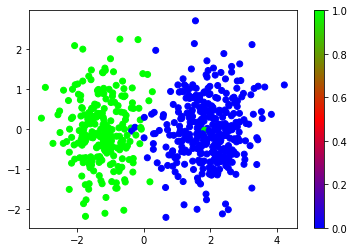

In [89]:
poliblog_test_latent_space, poliblog_test_decoded_labels, poliblog_train_latent_space, poliblog_train_decoded_labels = get_latent_space(
    train_data=poliblog_data_train_perm, 
    train_labels=poliblog_ratings_train_one_hot_perm, 
    test_data=poliblog_data_test, 
    test_labels=poliblog_ratings_test_one_hot, 
    encoder=poliblog_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=poliblog_ratings_train_one_hot_perm,
    mixture_assignments_test=poliblog_ratings_test_one_hot
)
plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
plt.colorbar()


Starting autoencoder. Log folder=/tmp/class_vae/deep/08_05_2019/20190508191622
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 18]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 11
epoch: 0
Train accuracy 0.7237196564674377
Test accuracy 0.7099999785423279
epoch: 1
Train accuracy 0.7318059206008911
Test accuracy 0.7149999737739563
epoch: 2
Train accuracy 0.8261455297470093
Test accuracy 0.7850000262260437
epoch: 3
Train accuracy 0.8733153343200684
Test accuracy 0.8650000095367432
epoch: 4
Train accuracy 0.8948786854743958
Test accuracy 0.8650000095367432


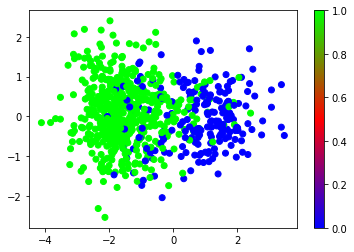

In [90]:
smsSpam_test_latent_space, smsSpam_test_decoded_labels, smsSpam_train_latent_space, smsSpam_train_decoded_labels = get_latent_space(
    train_data=smsSpam_data_train_perm, 
    train_labels=smsSpam_labels_train_one_hot_perm, 
    test_data=smsSpam_data_test, 
    test_labels=smsSpam_labels_test_one_hot, 
    encoder=smsSpam_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=smsSpam_labels_train_one_hot_perm,
    mixture_assignments_test=smsSpam_labels_test_one_hot
)
plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517142805
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 2]
self.y.shape [None, 2]
xy.shape [None, 2002]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 16
epoch: 0
Train accuracy 0.9595864415168762
Test accuracy 0.9124293923377991
epoch: 1
Train accuracy 0.9877819418907166
Test accuracy 0.9124293923377991
epoch: 2
Train accuracy 0.9981203079223633
Test accuracy 0.9279661178588867
epoch: 3
Train accuracy 1.0
Test accuracy 0.959039568901062
epoch: 4
Train accuracy 1.0
Test accuracy 0.959039568901062


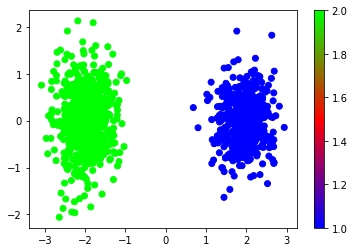

In [263]:
reuters2_test_latent_space, reuters2_test_decoded_labels, reuters2_train_latent_space, reuters2_train_decoded_labels = get_latent_space(
    train_data=reuters2_data_train_perm, 
    train_labels=reuters2_labels_train_one_hot_perm, 
    test_data=reuters2_data_test, 
    test_labels=reuters2_labels_test_one_hot, 
    encoder=reuters2_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters2_labels_train_one_hot_perm,
    mixture_assignments_test=reuters2_labels_test_one_hot
)
plt.scatter(reuters2_train_latent_space[:,0],reuters2_train_latent_space[:,1], c=reuters2_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517142813
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 3]
self.y.shape [None, 3]
xy.shape [None, 2003]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 25
epoch: 0
Train accuracy 0.6821752190589905
Test accuracy 0.6225045323371887
epoch: 1
Train accuracy 0.9377643465995789
Test accuracy 0.7894737124443054
epoch: 2
Train accuracy 0.9873111844062805
Test accuracy 0.8411978483200073
epoch: 3
Train accuracy 0.998791515827179
Test accuracy 0.8484573364257812
epoch: 4
Train accuracy 0.9981873035430908
Test accuracy 0.8430126905441284


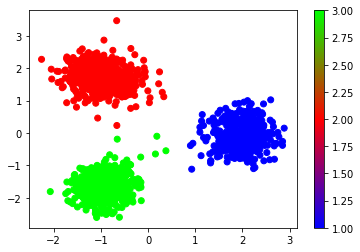

In [264]:
reuters3_test_latent_space, reuters3_test_decoded_labels, reuters3_train_latent_space, reuters3_train_decoded_labels = get_latent_space(
    train_data=reuters3_data_train_perm, 
    train_labels=reuters3_labels_train_one_hot_perm, 
    test_data=reuters3_data_test, 
    test_labels=reuters3_labels_test_one_hot, 
    encoder=reuters3_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters3_labels_train_one_hot_perm,
    mixture_assignments_test=reuters3_labels_test_one_hot
)
plt.scatter(reuters3_train_latent_space[:,0],reuters3_train_latent_space[:,1], c=reuters3_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517142910
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 5]
self.y.shape [None, 5]
xy.shape [None, 2005]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 44
epoch: 0
Train accuracy 0.44456252455711365
Test accuracy 0.37626397609710693
epoch: 1
Train accuracy 0.7995041012763977
Test accuracy 0.5944651365280151
epoch: 2
Train accuracy 0.9496989250183105
Test accuracy 0.7152740955352783
epoch: 3
Train accuracy 0.9847679734230042
Test accuracy 0.7339010238647461
epoch: 4
Train accuracy 0.9936237931251526
Test accuracy 0.7472059726715088


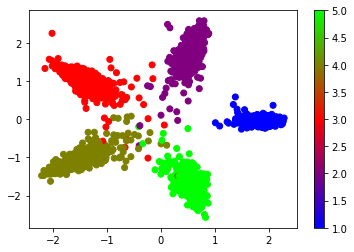

In [265]:
reuters5_test_latent_space, reuters5_test_decoded_labels, reuters5_train_latent_space, reuters5_train_decoded_labels = get_latent_space(
    train_data=reuters5_data_train_perm, 
    train_labels=reuters5_labels_train_one_hot_perm, 
    test_data=reuters5_data_test, 
    test_labels=reuters5_labels_test_one_hot, 
    encoder=reuters5_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=reuters5_labels_train_one_hot_perm,
    mixture_assignments_test=reuters5_labels_test_one_hot
)
plt.scatter(reuters5_train_latent_space[:,0],reuters5_train_latent_space[:,1], c=reuters5_train_decoded_labels, cmap='brg')
plt.colorbar()

Starting autoencoder. Log folder=/tmp/class_vae/deep/17_05_2019/20190517142203
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9544761776924133
Test accuracy 0.9435714483261108
epoch: 1
Train accuracy 0.9683333039283752
Test accuracy 0.9541428685188293
epoch: 2
Train accuracy 0.9744444489479065
Test accuracy 0.9578571319580078
epoch: 3
Train accuracy 0.9792222380638123
Test accuracy 0.9652857184410095
epoch: 4
Train accuracy 0.9822539687156677
Test accuracy 0.9660000205039978


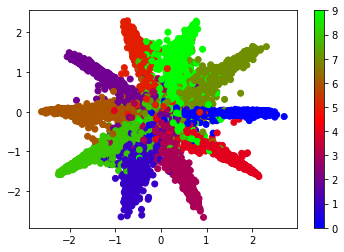

In [261]:
label_mapping = {
    0: 0,
    1: 7,
    2: 4,
    3: 8,
    4: 9,
    5: 3,
    6: 5,
    7: 1,
    8: 6,
    9: 2
}

mixture_assignments_train = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_train_perm)

mixture_assignments_test = create_mixture_assignments(
    label_mapping=label_mapping, 
    onehot_encoder=mnist_onehot_encoder, 
    y_train=mnist_labels_test)

mnist_test_latent_space, mnist_test_decoded_labels,mnist_train_latent_space, mnist_train_decoded_labels = get_latent_space(
    train_data=mnist_train_perm, 
    train_labels=mnist_labels_train_perm, 
    test_data=mnist_test, 
    test_labels=mnist_labels_test, 
    encoder=mnist_onehot_encoder,
    omega=1.0,
    mixture_assignments_train=mixture_assignments_train,
    mixture_assignments_test=mixture_assignments_test,
)
plt.scatter(mnist_train_latent_space[:,0],mnist_train_latent_space[:,1], c=mnist_train_decoded_labels, cmap='brg')
plt.colorbar()

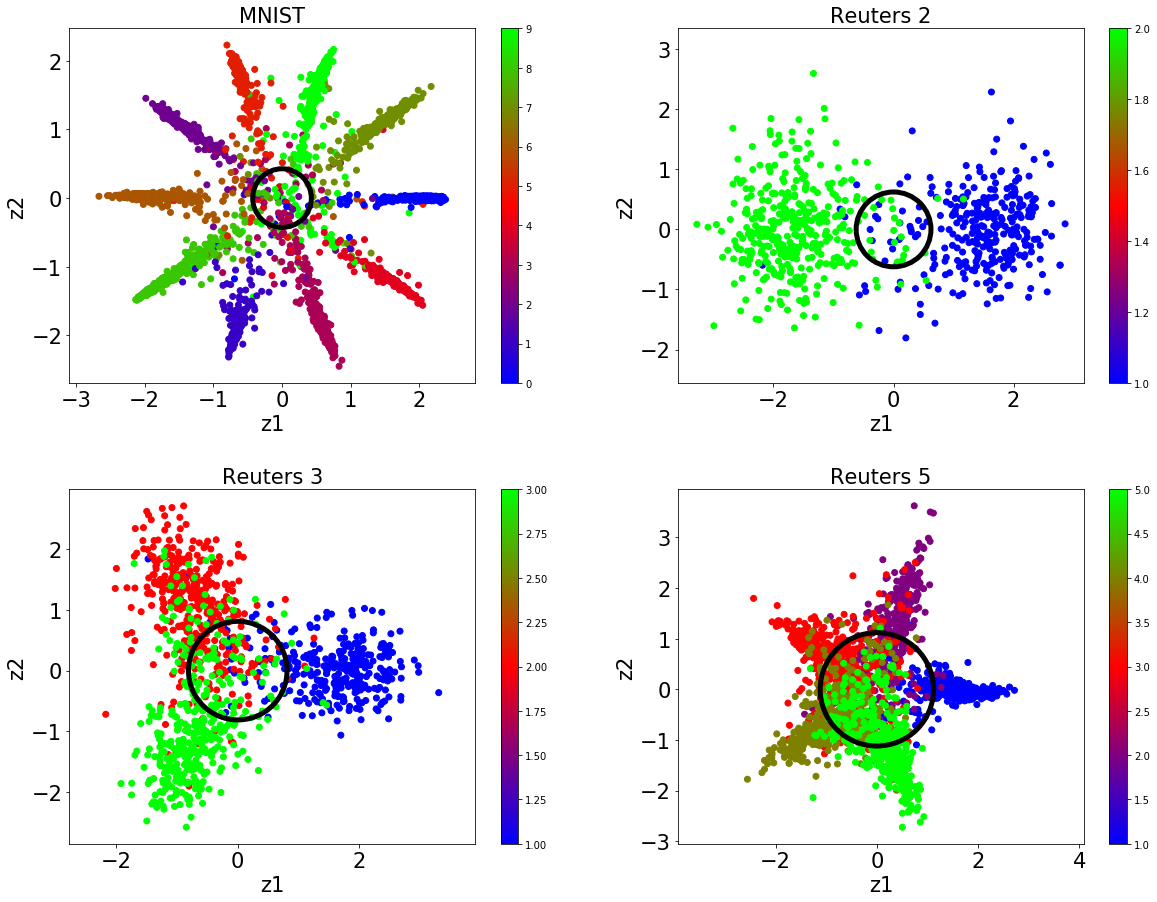

In [270]:
fig = plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.scatter(mnist_test_latent_space[:,0],mnist_test_latent_space[:,1], c=mnist_test_decoded_labels, cmap='brg')
plt.colorbar()
plt.axis('equal')
circle1=plt.Circle((0,0),0.42712283,color='r')
plt.gcf().gca().add_artist(circle1)
circle1.set_facecolor( "none" )
circle1.set_linewidth(5.0)
circle1.set_edgecolor("black")

plt.title("MNIST",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)

# plt.subplot(3, 2, 2)
# plt.scatter(poliblog_train_latent_space[:,0],poliblog_train_latent_space[:,1], c=poliblog_train_decoded_labels, cmap='brg')
# plt.colorbar()

# plt.title("Visualisation of 2D latent space for poliblog dataset")
# plt.xlabel("z_1")
# plt.ylabel("z_2")

# plt.subplot(3, 2, 3)
# plt.scatter(smsSpam_train_latent_space[:,0],smsSpam_train_latent_space[:,1], c=smsSpam_train_decoded_labels, cmap='brg')
# plt.colorbar()

# plt.title("Visualisation of 2D latent space for smsSpam dataset")
# plt.xlabel("z_1 (Number of features)")
# plt.ylabel("z_2")

plt.subplot(2, 2, 2)
plt.scatter(reuters2_test_latent_space[:,0],reuters2_test_latent_space[:,1], c=reuters2_test_decoded_labels, cmap='brg')
plt.colorbar()

plt.title("Reuters 2",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)
circle6=plt.Circle((0,0),0.62275429,color='r')
plt.gcf().gca().add_artist(circle6)
circle6.set_facecolor( "none" )
circle6.set_linewidth(5.0)
circle6.set_edgecolor("black")
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.scatter(reuters3_test_latent_space[:,0],reuters3_test_latent_space[:,1], c=reuters3_test_decoded_labels, cmap='brg')
plt.colorbar()
plt.title("Reuters 3",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)
plt.axis('equal')
circle5=plt.Circle((0,0),0.81037036,color='r')
plt.gcf().gca().add_artist(circle5)
circle5.set_facecolor( "none" )
circle5.set_linewidth(5.0)
circle5.set_edgecolor("black")


plt.subplot(2, 2, 4)
plt.scatter(reuters5_test_latent_space[:,0], [:,1], c=reuters5_test_decoded_labels, cmap='brg')
plt.colorbar()
plt.title("Reuters 5",fontsize=21)
plt.xlabel("z1",fontsize=21)
plt.ylabel("z2",fontsize=21)
plt.tick_params(axis='both', which='major', labelsize=21)
circle6=plt.Circle((0,0),1.11990874,color='r')
plt.gcf().gca().add_artist(circle6)
circle6.set_facecolor( "none" )
circle6.set_linewidth(5.0)
circle6.set_edgecolor("black")
plt.axis('equal')

plt.savefig('/Users/mjankowski/Desktop/sup_latent_space_with_threshold_98.png', bbox_inches='tight')
plt.show()

/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/vae_tests/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


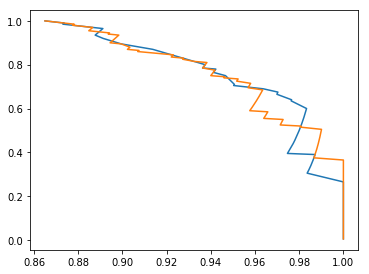

In [135]:
fig = plt.figure(figsize=(20, 15))
rows=3
columns=3
base_pos=1
smsSpam_prediction, smsSpam_z_score_arr_unnorm, smsSpam_y_score_arr = smsSpam_dslgmm.predict(smsSpam_data_test)
smsSpam_max_score = np.max(smsSpam_z_score_arr_unnorm)
smsSpam_z_score_arr = smsSpam_z_score_arr_unnorm / smsSpam_max_score
thresholds = np.concatenate([np.linspace(0,0.99,1000),np.linspace(0.99, 1.0,1000)])
smsSpam_accuracy_plot = [accuracy_for_score(smsSpam_prediction, smsSpam_labels_test_one_hot, smsSpam_z_score_arr, threshold) for threshold in thresholds]
smsSpam_class_ratio = [classification_ratio(smsSpam_z_score_arr, threshold) for threshold in thresholds]

smsSpam_y_accuracy_plot = [accuracy_for_score(smsSpam_prediction, smsSpam_labels_test_one_hot, smsSpam_y_score_arr, threshold) for threshold in thresholds]
smsSpam_y_class_ratio = [classification_ratio(smsSpam_y_score_arr, threshold) for threshold in thresholds]



plt.subplot(rows, columns, base_pos)
#     plt.plot(class_ratio, accuracy_plot, label='||z||')
#     plt.plot(y_class_ratio, y_accuracy_plot, label='P(y)')

plt.plot(smsSpam_accuracy_plot, smsSpam_class_ratio, label='||z||')
plt.plot(smsSpam_y_accuracy_plot, smsSpam_y_class_ratio, label='P(y)')

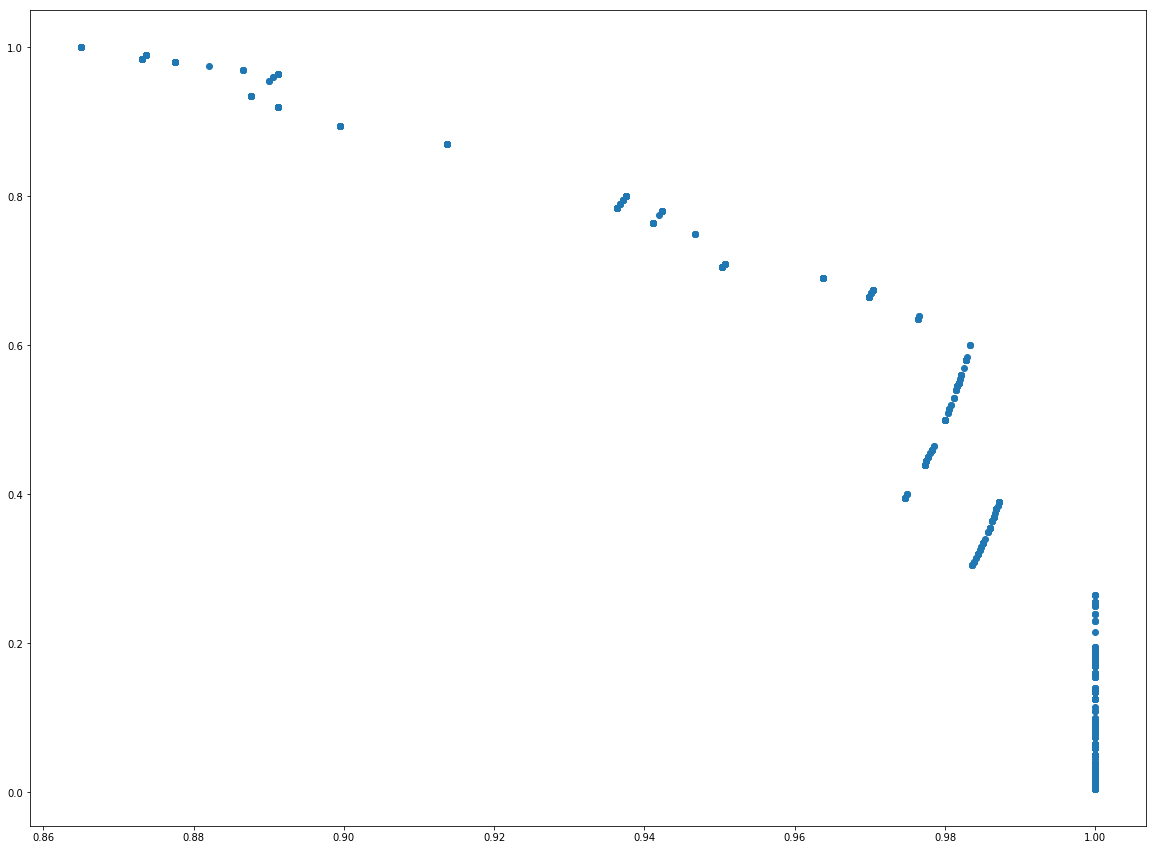

In [171]:
smsSpam_plot = pd.DataFrame({
    'accuracy': smsSpam_accuracy_plot, 
    'class_ratio': smsSpam_class_ratio
})
fig = plt.figure(figsize=(20, 15))
plt.plot(smsSpam_plot['accuracy'].values, smsSpam_plot['class_ratio'].values, 'o')


In [159]:
#smsSpam_plot.groupby('accuracy', as_index=False).max()

In [204]:
smsSpam_corrected = smsSpam_plot.groupby(['accuracy'], as_index=False).max()
# smsSpam_corrected #.columns = ['accuracy', 'class_ratio']
# smsSpam_plot.groupby('accuracy', as_index=False).max()

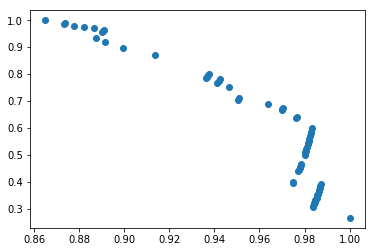

In [183]:
plt.plot(smsSpam_corrected['accuracy'].values, smsSpam_corrected['class_ratio'].values, 'o')

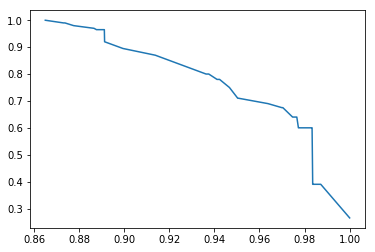

In [208]:
my_sps_plot = correct_accuracy_class_ratio_chart(smsSpam_accuracy_plot, smsSpam_class_ratio)
plt.plot(my_sps_plot['accuracy'].values, my_sps_plot['class_ratio'].values)


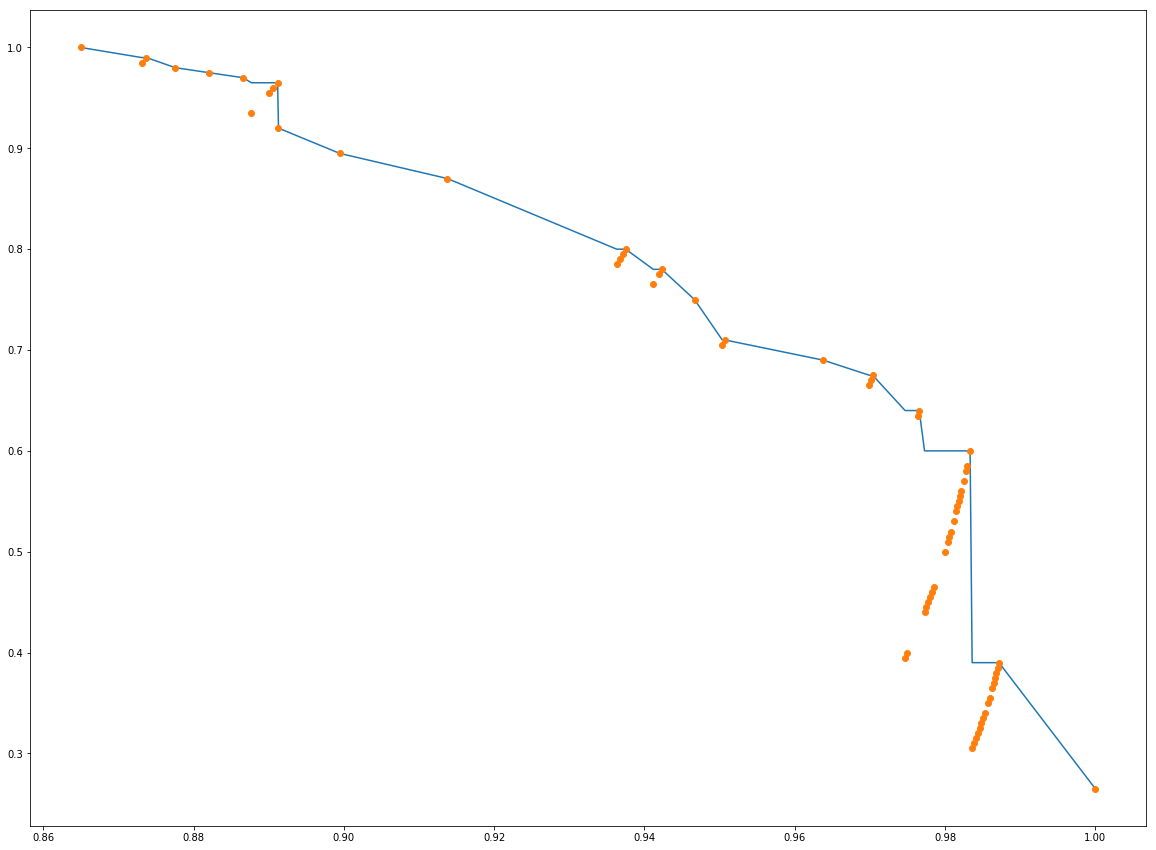

In [203]:
fig = plt.figure(figsize=(20, 15))

plt.plot(smsSpam_corrected_sorted_fixed['accuracy'].values, smsSpam_corrected_sorted_fixed['class_ratio'].values)
plt.plot(smsSpam_corrected['accuracy'].values, smsSpam_corrected['class_ratio'].values, 'o')
plt.show()


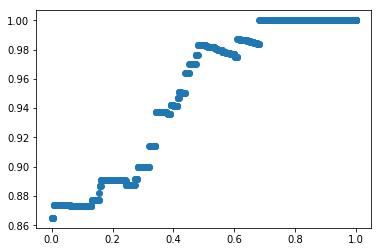

In [185]:

plt.plot(thresholds, smsSpam_accuracy_plot, 'o')